#### **FEATURE ENGINEERING**
In this phase, we will transform the raw data into a more structured and informative form suitable for modeling Remaining Useful Life (RUL). The key steps include:

**Target Variable Construction (RUL)**:
A new feature, Remaining Useful Life (RUL), will be created as the difference between the maximum cycle for each engine and its current cycle. This variable will serve as the primary target for predictive modeling.

**Outlier Treatment**:
Outliers identified during the EDA—particularly in sensor measurements and operational settings—will be handled using appropriate statistical or transformation techniques. This step ensures that extreme values do not bias the model or distort learned relationships.

**Feature Reduction (Low-Variance Columns)**:
Columns exhibiting extremely low variability, as observed in the EDA, will be dropped. These features provide limited informational value, introduce redundancy, and may contribute noise, thereby reducing model efficiency and interpretability.

**Multicollinearity Handling**:
The correlation matrix from the EDA revealed strong correlations among several sensor measurements, indicating multicollinearity. To address this, correlated features will be carefully analyzed, and techniques such as feature selection or dimensionality reduction (e.g., Principal Component Analysis) will be applied to mitigate redundancy and improve model stability.

**Feature Scaling**:
All numerical features will be scaled (e.g., using Min-Max scaling or Standardization) to bring them into a comparable range. This step is crucial for algorithms sensitive to feature magnitudes, ensuring stable convergence and balanced influence of features during training.

In [38]:
 # import dependancies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold

In [39]:
 # Setting up the visualization style 
sns.set_style( style = 'darkgrid' )
sns.set_palette( palette = 'icefire' )

In [ ]:
 # loading the dataset  
column_names = ['engine_id', 'cycle'] + \
               [f'operational_setting_{i}' for i in range(1, 4)] + \
               [f'sensor_measurement_{i}' for i in range(1, 22)]

rul_col_names = ['RUL']

 # Loading the train data
train_df_FD001 = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=column_names)
train_df_FD002 = pd.read_csv('train_FD002.txt', sep='\s+', header=None, names=column_names)
train_df_FD003 = pd.read_csv('train_FD003.txt', sep='\s+', header=None, names=column_names)
train_df_FD004 = pd.read_csv('train_FD004.txt', sep='\s+', header=None, names=column_names)

 # Loading the test data
test_df_FD001 = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=column_names)
test_df_FD002 = pd.read_csv('test_FD002.txt', sep='\s+', header=None, names=column_names)
test_df_FD003 = pd.read_csv('test_FD003.txt', sep='\s+', header=None, names=column_names)
test_df_FD004 = pd.read_csv('test_FD004.txt', sep='\s+', header=None, names=column_names)

 # Loading the RUL
RUL_df_FD001 = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=rul_col_names)
RUL_df_FD002 = pd.read_csv('RUL_FD002.txt', sep='\s+', header=None, names=rul_col_names)
RUL_df_FD003 = pd.read_csv('RUL_FD003.txt', sep='\s+', header=None, names=rul_col_names)
RUL_df_FD004 = pd.read_csv('RUL_FD004.txt', sep='\s+', header=None, names=rul_col_names)

In [41]:
 # Dataframes
test_dfs = { 
       'test_FD001':test_df_FD001, 
       'test_FD002':test_df_FD002, 
       'test_FD003':test_df_FD003, 
       'test_FD004':test_df_FD004
       }

train_dfs = {
       'train_FD001':train_df_FD001, 
       'train_FD002':train_df_FD002, 
       'train_FD003':train_df_FD003, 
       'train_FD004':train_df_FD004
}

RUL_dfs = {
    'RUL_FD001': RUL_df_FD001,
    'RUL_FD002': RUL_df_FD002,
    'RUL_FD003': RUL_df_FD003,
}

In [42]:
 # Adding RUL in the train df 
for name , df in train_dfs.items():
    max_cycles = df.groupby('engine_id')['cycle'].max().reset_index().rename(columns = {'engine_id' : 'engine_id' , 'cycle' : 'Max_cycle'})
    df = pd.merge(df, max_cycles, on = 'engine_id' )
    train_dfs[name] = df

for name , df in train_dfs.items():
    df['RUL'] = df['Max_cycle']-df['cycle']
    df = df.drop('Max_cycle', axis=1)
    train_dfs[name] = df

In [45]:
 # getting the statistical description of RUL
for name , df in train_dfs.items():
    display(df['RUL'].describe())

count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

count    53759.000000
mean       108.154746
std         69.180569
min          0.000000
25%         51.000000
50%        103.000000
75%        156.000000
max        377.000000
Name: RUL, dtype: float64

count    24720.000000
mean       138.077063
std         98.846675
min          0.000000
25%         61.000000
50%        123.000000
75%        190.000000
max        524.000000
Name: RUL, dtype: float64

count    61249.000000
mean       133.311417
std         89.783389
min          0.000000
25%         61.000000
50%        122.000000
75%        190.000000
max        542.000000
Name: RUL, dtype: float64

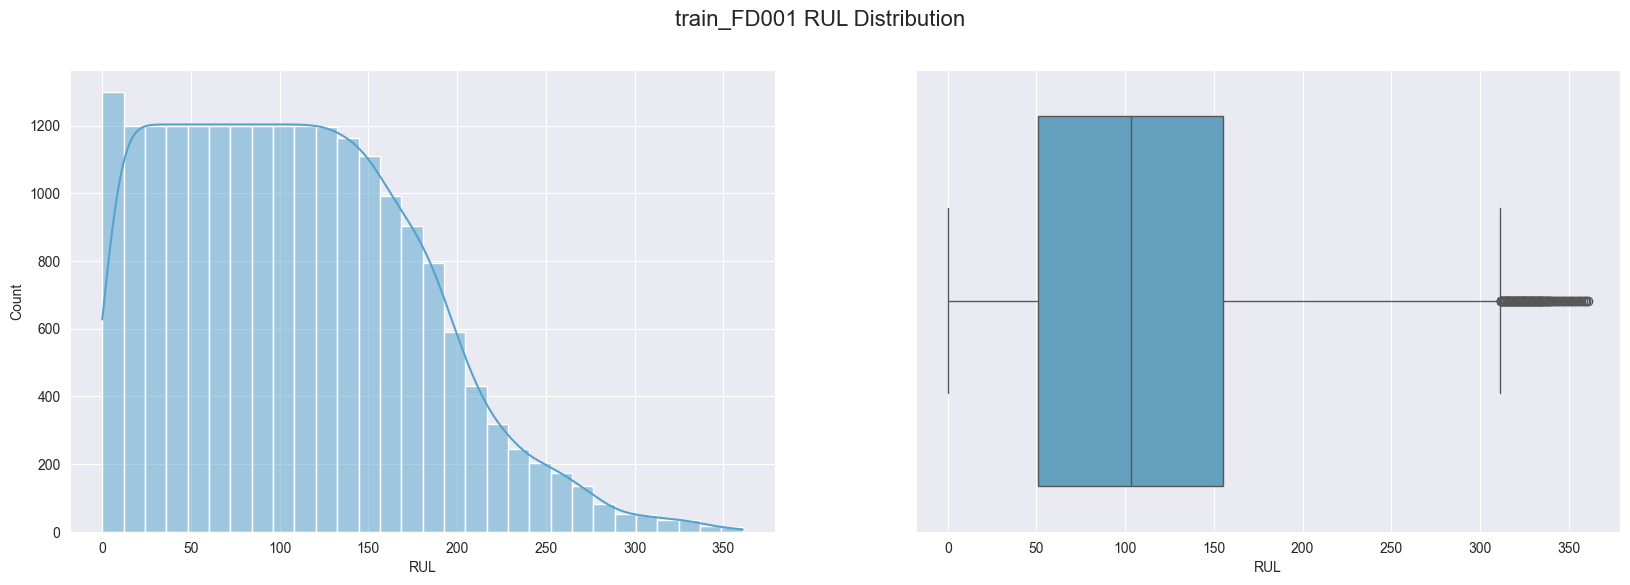

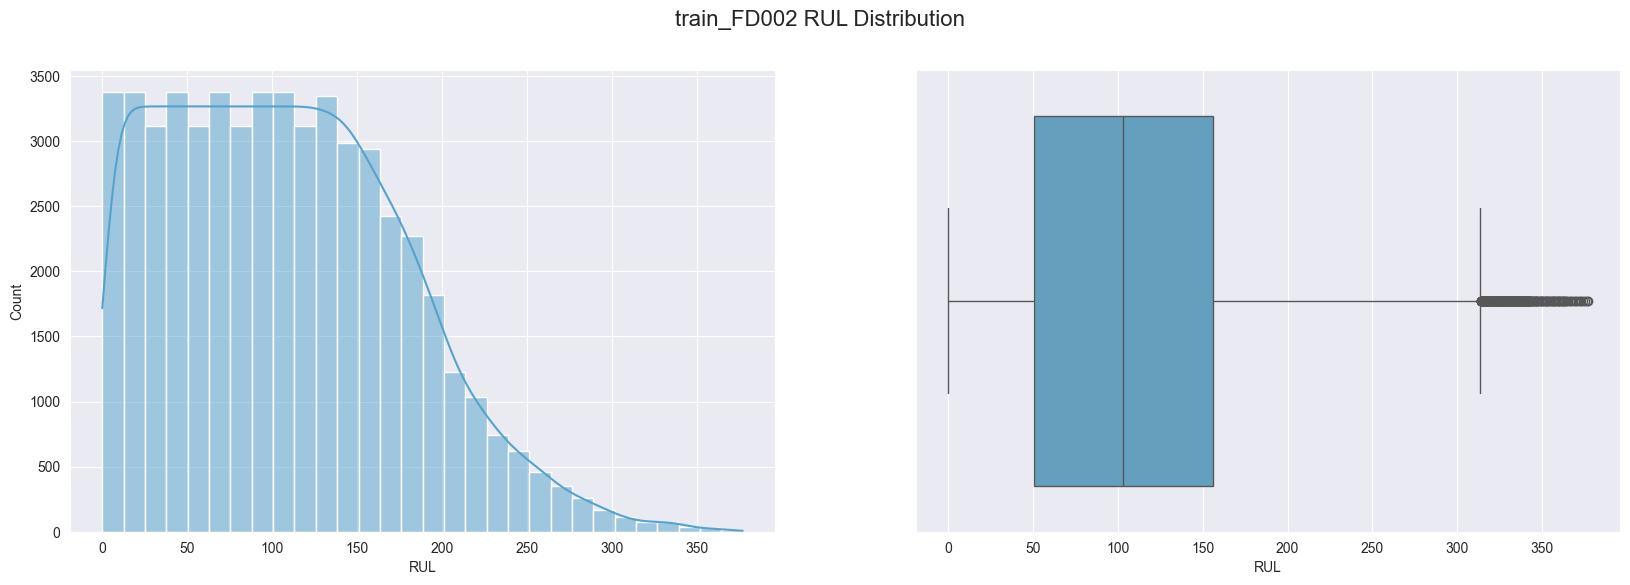

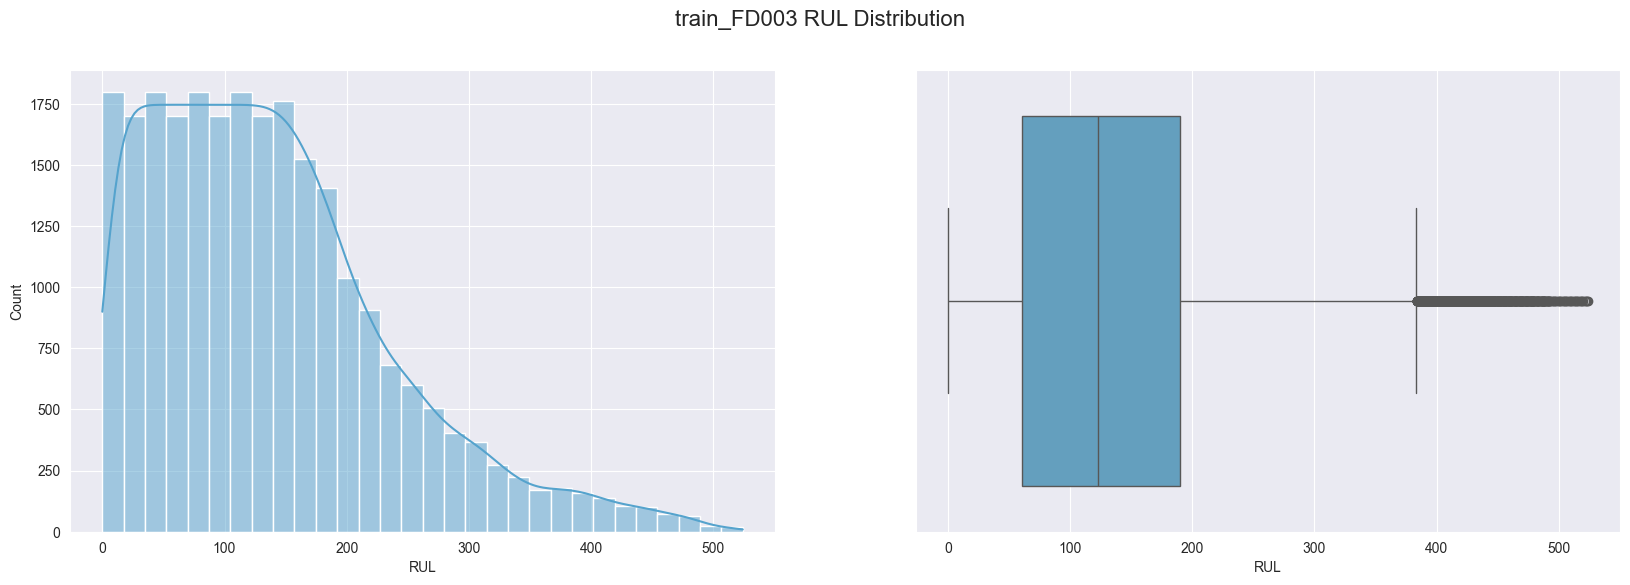

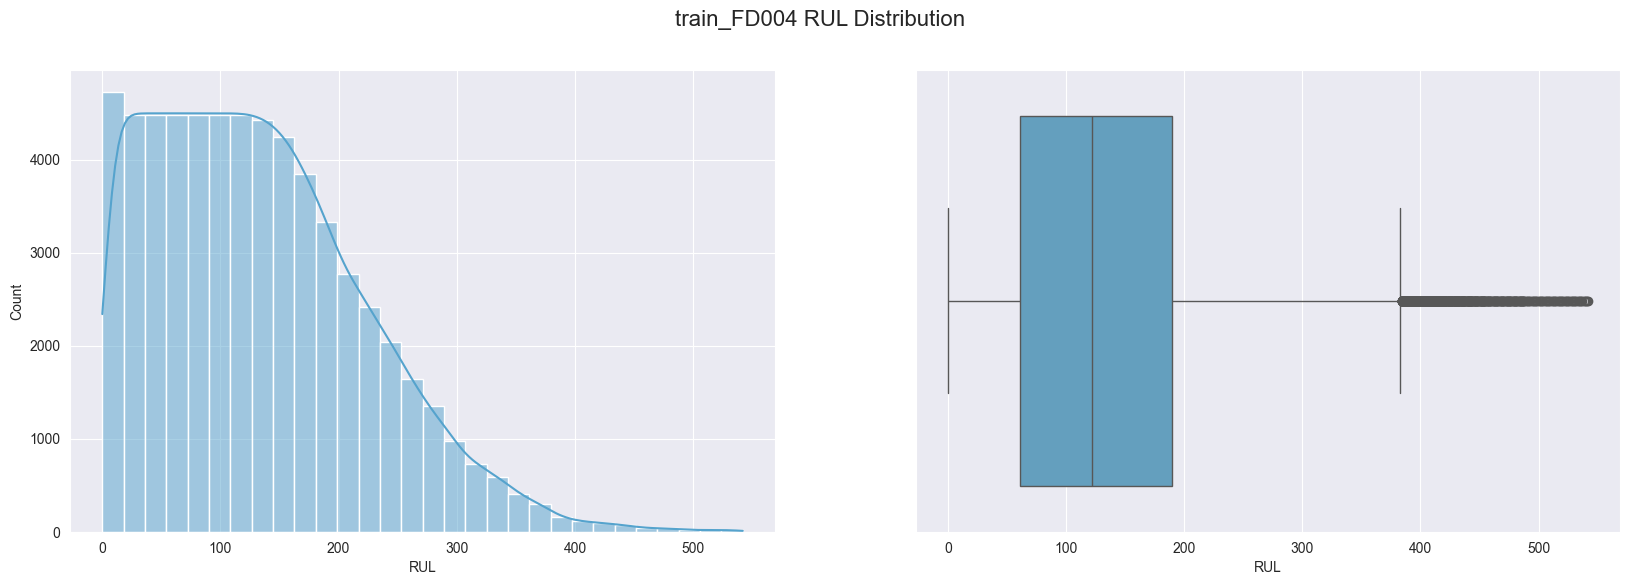

In [43]:
 # Plotting the distribution of RUL
for name , df in train_dfs.items():
    fig, ax = plt.subplots( nrows=1, ncols =2 , figsize=(20,6) )
    ax.flatten()
    
    sns.histplot(x = df['RUL'] , kde = True , bins = 30 ,ax = ax[0])
    sns.boxplot(x = df['RUL'] , ax = ax[1])

    plt.suptitle(f"{name} RUL Distribution" , fontsize = 16 )
    plt.show()

The distribution of the newly created RUL column is right-skewed, similar to the distribution of the actual RUL provided in the test data. Most engines exhibit a Remaining Useful Life in the range of 0–150 cycles, while only a few engines have significantly higher RUL values.

We will then try to remove columns with a low variability.

In [ ]:
threshold_n = 0.1
sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))

for name , df in train_dfs.items():

    sel_var=sel.fit_transform(df)
    df[df.columns[sel.get_support(indices=True)]]
    display(df)